# Investment Case Study

In [2]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import warnings
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)

In [3]:
#Trying to find the correct encoding of 'rounds2.csv'

with open('rounds2.csv','rb') as rawdata:
    result = chardet.detect(rawdata.read(30000))
    
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [4]:
#Trying to find the correct encoding of 'companies.csv'

with open('companies.csv','rb') as rawdata:
    result = chardet.detect(rawdata.read(30000))
    
print(result)

{'encoding': 'utf-8', 'confidence': 0.938125, 'language': ''}


In [5]:
#Loading the files as dataframes with a suitable encoding

rounds2 = pd.read_csv('rounds2.csv', encoding='ISO-8859-1')
companies = pd.read_csv('companies.csv',encoding='ISO-8859-1')

In [6]:
# Since the files were not perfectly encoded, I encoded then with the most common encoding 
#To get rid of symbols again decode using ASCII

companies.permalink = companies.permalink.str.encode('utf-8').str.decode('ascii','ignore')
rounds2.company_permalink = rounds2.company_permalink.str.encode('utf-8').str.decode('ascii','ignore')

In [7]:
#Converting the Unique ID column in all lower case so that the files can be merged properly

rounds2.company_permalink = rounds2.company_permalink.str.lower()
companies.permalink = companies.permalink.str.lower()

In [8]:
#Dropping duplicate rows in both the datasets given 

rounds2.drop_duplicates(subset=['company_permalink'], inplace=True)
companies.drop_duplicates(subset=['permalink'], inplace=True)

### Checkpoint 1
##### Finding the unique rows in both the data sets

In [9]:
companies.permalink.value_counts()

/organization/natural-machines         1
/organization/nanotron-technologies    1
/organization/toymail-co-              1
/organization/robauto                  1
/organization/bio-logic                1
                                      ..
/organization/mobile-interaction       1
/organization/canibal                  1
/organization/explain-my-surgery       1
/organization/stempowerkids            1
/organization/bekiz                    1
Name: permalink, Length: 66368, dtype: int64

In [10]:
rounds2.company_permalink.value_counts()

/organization/natural-machines         1
/organization/nanotron-technologies    1
/organization/toymail-co-              1
/organization/robauto                  1
/organization/bio-logic                1
                                      ..
/organization/mobile-interaction       1
/organization/canibal                  1
/organization/explain-my-surgery       1
/organization/stempowerkids            1
/organization/bekiz                    1
Name: company_permalink, Length: 66368, dtype: int64

##### Merging both datasets in one 

In [11]:
#Merging both data sets into one.
master_frame = pd.merge(companies, rounds2, how='inner', left_on='permalink', right_on = 'company_permalink')

In [12]:
# Dropping the redundant column
master_frame = master_frame.drop(['company_permalink'], axis=1)


# Data cleaning 
### treating null values

In [13]:
# Finding percentage of missing values
round(100*(master_frame.isnull().sum()/len(master_frame.index)),3)

permalink                   0.000
name                        0.002
homepage_url                7.621
category_list               4.743
status                      0.000
country_code               10.484
state_code                 12.878
region                     12.099
city                       12.096
founded_at                 22.934
funding_round_permalink     0.000
funding_round_type          0.000
funding_round_code         78.699
funded_at                   0.000
raised_amount_usd          21.920
dtype: float64

In [14]:
# Dropping the column 'funding_round_code' since it has many missing values
master_frame = master_frame.drop(['funding_round_code'],axis=1)

In [15]:
#dropping columns that are not required for current analysis and this assignment

master_frame = master_frame.drop(['homepage_url','status','state_code','region','city','founded_at','funded_at'], axis=1)

In [16]:
#removing rows with more than 8 missing values
master_frame = master_frame[~(master_frame.isnull().sum(axis=1)>=8)]

In [17]:
# Removing rows which have missing name(just 1 row)
master_frame = master_frame[~master_frame.name.isnull()]

In [18]:
#Removing the rows with null category list
#These will not contribute to our analysis when categories are analyzed

master_frame = master_frame[pd.notnull(master_frame['category_list'])]

In [19]:
#Removing the rows with no country code as these will not contribute to country analysis

master_frame = master_frame[pd.notnull(master_frame['country_code'])]

In [20]:
#Checking the percentage of missing values again

round(100*(master_frame.isnull().sum()/len(master_frame.index)),3)

permalink                   0.000
name                        0.000
category_list               0.000
country_code                0.000
funding_round_permalink     0.000
funding_round_type          0.000
raised_amount_usd          19.118
dtype: float64

### Checkpoint 2


In [21]:
# Retaining the rows with Funding Round type as Seed, angel, venture or Private equity only
master_frame = master_frame[master_frame.funding_round_type.isin(['seed','angel','venture','private_equity'])]

In [22]:
# Getting 90 percentile data
getting_quantile = master_frame.groupby(['funding_round_type']).quantile(0.90)
gqd= getting_quantile.to_dict()

In [23]:
# Getting rid of outliers beyong 90 percentile
master_frame = master_frame[~((master_frame.raised_amount_usd > gqd['raised_amount_usd']['angel']) & (master_frame.funding_round_type == 'angel'))]
master_frame = master_frame[~((master_frame.raised_amount_usd > gqd['raised_amount_usd']['seed']) & (master_frame.funding_round_type == 'seed'))]
master_frame = master_frame[~((master_frame.raised_amount_usd > gqd['raised_amount_usd']['venture']) & (master_frame.funding_round_type == 'venture'))]
master_frame = master_frame[~((master_frame.raised_amount_usd > gqd['raised_amount_usd']['private_equity']) & (master_frame.funding_round_type == 'private_equity'))]


In [24]:
#imputing the median to missing values
master_frame['raised_amount_usd'] = master_frame['raised_amount_usd'].fillna(master_frame.groupby('funding_round_type')['raised_amount_usd'].transform('median'))
master_frame['raised_amount_usd'] = master_frame['raised_amount_usd'].fillna(master_frame['raised_amount_usd'].median())


In [25]:
# Getting median of all the venture types
getting_median = master_frame.groupby(['funding_round_type']).median()
gmd= getting_median.to_dict()
gmd

{'raised_amount_usd': {'angel': 320000.0,
  'private_equity': 17000000.0,
  'seed': 200000.0,
  'venture': 3500000.0}}

In [26]:
# Sorting the master frame in descending order of the Raised Amounts

master_frame=master_frame.sort_values(by="raised_amount_usd", ascending = False)

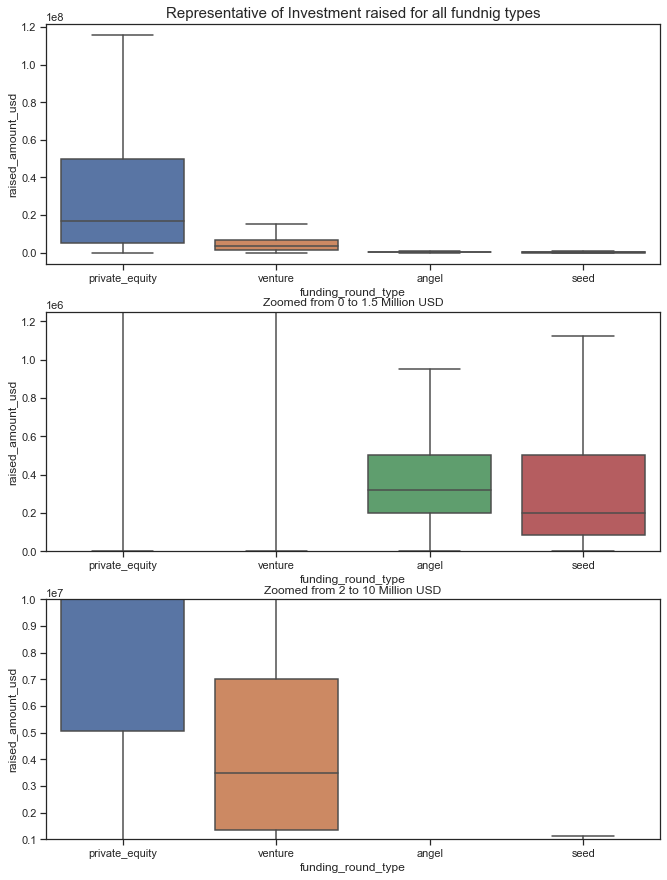

In [70]:
#Plotting a boxplot to compare the medians of all types of funds


fig = plt.figure(figsize=(11,15))
plt.xlabel("Funding Type", fontsize= 12)
plt.ylabel("Raised Funding Amount", fontsize= 12)

plt.subplot(311)
plt.ylabel("Raised Funding Amount", fontsize= 12)

plt.title("Representative of Investment raised for all fundnig types", fontsize= 15)

sns.boxplot(data = master_frame , x='funding_round_type' , y= 'raised_amount_usd', showfliers=False)
plt.subplot(312)
plt.ylim([0,1250000])
plt.title("Zoomed from 0 to 1.5 Million USD", fontsize= 12)

sns.boxplot(data = master_frame , x='funding_round_type' , y= 'raised_amount_usd', showfliers=False)
plt.subplot(313)
plt.ylim([1000000,10000000])
plt.title("Zoomed from 2 to 10 Million USD", fontsize= 12)

sns.boxplot(data = master_frame , x='funding_round_type' , y= 'raised_amount_usd', showfliers=False)


plt.savefig("plot1_b.png")
plt.show()

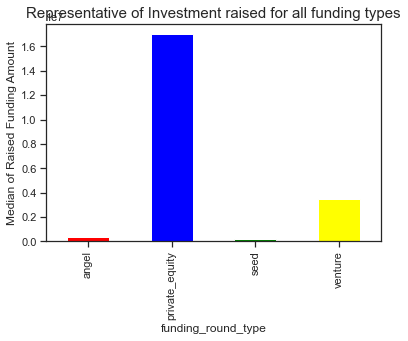

In [71]:
#Plotting just the medians of 4 investment types 

plt.xlabel("Funding Type", fontsize= 12)
plt.ylabel("Median of Raised Funding Amount", fontsize= 12)
plt.title("Representative of Investment raised for all funding types", fontsize= 15)

master_frame.groupby('funding_round_type')['raised_amount_usd'].median().plot(kind='bar', color=['red','blue','green','yellow'])
plt.savefig("plot1_a.png")
plt.show()


##### With this we observe that the Venture type of funding is most suitable for Spark Funds to invest since the median(most representative value) lies between/near the 5-15Million USD mark


## Checkpoint 3 

### Country Analysis

In [29]:
# Retaining only the data with Funding type Venture as that is the appropriate tyoe for Sparks Fund
master_venture = master_frame[master_frame.funding_round_type=="venture"]

#Sorting the data in descending order by the Raised amount 
master_venture = master_venture.sort_values(by="raised_amount_usd", ascending = False)


In [30]:
# Finding the total investments per country
df1=master_venture.groupby(['country_code']).sum(['raised_amount_usd'])

# Sorting them in descending order of Raised funding amount
df1 = df1.sort_values('raised_amount_usd', ascending=False)

In [31]:
# Getting the list of top 9 countries 

list_top9=df1.sort_values(by="raised_amount_usd", ascending=False).head(9).index
list_top9

Index(['USA', 'CHN', 'GBR', 'CAN', 'IND', 'FRA', 'ISR', 'DEU', 'CHE'], dtype='object', name='country_code')

##### Creating the top9 dataframe for venture type having records of top 9 countries

In [32]:
# As per checkpoint 3
top9 = master_venture[master_venture.country_code.isin(list_top9)]
top9.head()

,permalink,name,category_list,country_code,funding_round_permalink,funding_round_type,raised_amount_usd
43089,/organization/personalis,Personalis,Biotechnology,USA,/funding-round/389e773ed7457abe746aa41468c82ed1,venture,22000000.0
2249,/organization/akebia-therapeutics,Akebia Therapeutics,Biotechnology|Health Care,USA,/funding-round/13a35db5fae1f05a518eef6492b12ebd,venture,22000000.0
5963,/organization/battellepharma,BattellePharma,Pharmaceuticals,USA,/funding-round/88b265007745e6565311d261a1fde8c9,venture,22000000.0
21554,/organization/freedom-fuels,Freedom Fuels,Biofuels|Energy|Oil|Oil and Gas,USA,/funding-round/5fb3321b61261ffa3d8a51d752d8a35b,venture,22000000.0
15252,/organization/denovis,deNovis,Computers|Information Services|Software,USA,/funding-round/26fa5d6ea5f4532489c4307c42a6deae,venture,22000000.0


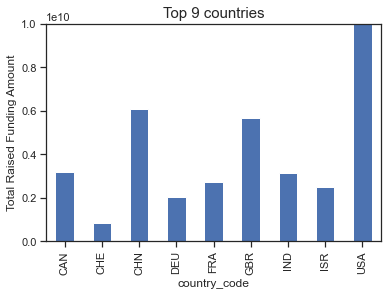

In [82]:
#Plotting a bar plot to give a visual representation of top 3 counties in terms if Total investment
plt.xlabel("Top 9 countries", fontsize= 12)
plt.ylabel("Total Raised Funding Amount", fontsize= 12)
plt.title("Top 9 countries", fontsize= 15)
plt.ylim([0,10000000000])
top9.groupby(by='country_code')['raised_amount_usd'].sum().plot(kind='bar')
plt.savefig("plot5.png")
plt.show()


## Checkpoint 4

In [34]:
#Creating a column: Primary Sector from Category list 
top9['primary_sector'] = top9['category_list'].str.split("|").str[0]
top9.head()

,permalink,name,category_list,country_code,funding_round_permalink,funding_round_type,raised_amount_usd,primary_sector
43089,/organization/personalis,Personalis,Biotechnology,USA,/funding-round/389e773ed7457abe746aa41468c82ed1,venture,22000000.0,Biotechnology
2249,/organization/akebia-therapeutics,Akebia Therapeutics,Biotechnology|Health Care,USA,/funding-round/13a35db5fae1f05a518eef6492b12ebd,venture,22000000.0,Biotechnology
5963,/organization/battellepharma,BattellePharma,Pharmaceuticals,USA,/funding-round/88b265007745e6565311d261a1fde8c9,venture,22000000.0,Pharmaceuticals
21554,/organization/freedom-fuels,Freedom Fuels,Biofuels|Energy|Oil|Oil and Gas,USA,/funding-round/5fb3321b61261ffa3d8a51d752d8a35b,venture,22000000.0,Biofuels
15252,/organization/denovis,deNovis,Computers|Information Services|Software,USA,/funding-round/26fa5d6ea5f4532489c4307c42a6deae,venture,22000000.0,Computers


In [35]:
#Reading the sector mapping file
mapping= pd.read_csv('mapping.csv')
mapping.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


In [36]:
#Creating long dataframe instead of wide from mapping.csv

id_vars=['category_list']
value_vars= list(np.setdiff1d(mapping.columns,id_vars))

In [37]:
# Using pandas.melt to create long format then dropping the value column
mapping_long=pd.melt(mapping, id_vars=id_vars, value_vars=value_vars)
mapping_long=mapping_long[mapping_long.value ==1]
mapping_long = mapping_long.drop('value',axis=1)


In [38]:
#Renaming the variable column to main_sector for Sector Analysis
mapping_long = mapping_long.rename(columns={'variable' : 'main_sector'})

In [39]:
# Creating a data frame where top9 primary sectors of top 9
## are merged with the main sectors
main_frame=pd.merge(top9,mapping_long,left_on="primary_sector",right_on="category_list", how="inner")

In [40]:
#Dropping the duplicate column
main_frame = main_frame.drop('category_list_y',axis=1)


## Checkpoint 5


##### No, we  have a data frame with each company’s main sector (main_sector) mapped to it


###### We create seperate dataframes for 3 top english speaking countries. (China excluded)


#### As per analysis above we found that three top countries are : USA, GBR, CAN

In [41]:
# Creating dataframe D1 for companies from USA 
### And with Total investment between 5-15 Million USD
D1 = main_frame[(main_frame.country_code =="USA") & ((main_frame.raised_amount_usd >= 5000000) & (main_frame.raised_amount_usd <=15000000))]

# Finding the number of entries
D1.permalink.value_counts()

/organization/bruin-biometrics               1
/organization/cipheroptics                   1
/organization/dachis-group                   1
/organization/reischling-press               1
/organization/deliveryagent                  1
                                            ..
/organization/applied-optoelectronics-inc    1
/organization/ogio-international             1
/organization/zebra-biologics                1
/organization/olx                            1
/organization/audigence                      1
Name: permalink, Length: 4661, dtype: int64

In [42]:
# Finding total investment made in USA
D1.raised_amount_usd.sum()

41046825657.0

In [43]:
# Finding number of investments in companies of each sector(USA)
D1.groupby(by='main_sector').count()

,permalink,name,category_list_x,country_code,funding_round_permalink,funding_round_type,raised_amount_usd,primary_sector
main_sector,,,,,,,,
Automotive & Sports,93,93,93,93,93,93,93,93
Cleantech / Semiconductors,872,872,872,872,872,872,872,872
Entertainment,250,250,250,250,250,250,250,250
Health,374,374,374,374,374,374,374,374
Manufacturing,373,373,373,373,373,373,373,373
"News, Search and Messaging",632,632,632,632,632,632,632,632
Others,1331,1331,1331,1331,1331,1331,1331,1331
"Social, Finance, Analytics, Advertising",736,736,736,736,736,736,736,736


###### We observe the top 3 sectors from the above table for USA and find the top company


In [44]:
# Company with most investment In the top sector of USA: Others
D1[D1.main_sector=="Others"].sort_values(by='raised_amount_usd', ascending=False)

,permalink,name,category_list_x,country_code,funding_round_permalink,funding_round_type,raised_amount_usd,primary_sector,main_sector
8068,/organization/softricity,Softricity,Software|Virtualization,USA,/funding-round/d25135f02fc6582912ca3d28b0f4349a,venture,15000000.0,Software,Others
8070,/organization/deploy-solution,Deploy Solution,Software,USA,/funding-round/a50ee5cf561a013a5381bf0009a8f893,venture,15000000.0,Software,Others
12383,/organization/silverback-systems,Silverback Systems,Web Hosting,USA,/funding-round/0cd4c7a1c43324e2427fdc7cd4ad0cb3,venture,15000000.0,Web Hosting,Others
12384,/organization/wichorus,WiChorus,Web Hosting,USA,/funding-round/264488982f239aea119091061975adb8,venture,15000000.0,Web Hosting,Others
12385,/organization/capella,Capella Photonics,Web Hosting,USA,/funding-round/1e16b0b59ed1ce01e71fb1bcd4590327,venture,15000000.0,Web Hosting,Others
...,...,...,...,...,...,...,...,...,...
3538,/organization/vbrick-systems,"VBrick Systems, Inc.",Enterprise Software,USA,/funding-round/17e1a08b34416e79d78009db48cce287,venture,5000000.0,Enterprise Software,Others
3536,/organization/victrio,Victrio,Enterprise Software|Fraud Detection|Mobile|Sec...,USA,/funding-round/37a49088d9a2c581ccfb5fdb60833771,venture,5000000.0,Enterprise Software,Others
3535,/organization/iperia,Iperia,Enterprise Software,USA,/funding-round/1413e28a4f02252df50a05d99b688475,venture,5000000.0,Enterprise Software,Others
3534,/organization/safe-technologies-international,Safe Technologies International,Enterprise Software,USA,/funding-round/f5b5c47b1088ca48ff1931f59c66113e,venture,5000000.0,Enterprise Software,Others


In [45]:
# In the top 2nd sector of USA: Cleantech / Semiconductors
D1[D1.main_sector=="Cleantech / Semiconductors"].sort_values(by='raised_amount_usd', ascending=False)

,permalink,name,category_list_x,country_code,funding_round_permalink,funding_round_type,raised_amount_usd,primary_sector,main_sector
178,/organization/tyrogenex,Tyrogenex,Biotechnology,USA,/funding-round/905091b7a4a78434733aabf9d4ccdd8a,venture,15000000.0,Biotechnology,Cleantech / Semiconductors
212,/organization/limerick-biopharma,Limerick BioPharma,Biotechnology,USA,/funding-round/21c1ea3c1fad8c2d6607680a86e95b1a,venture,15000000.0,Biotechnology,Cleantech / Semiconductors
214,/organization/advanced-animal-diagnostics,Advanced Animal Diagnostics,Biotechnology|Health Diagnostics,USA,/funding-round/1c25aa9afebfe5d5a851b69d3ab2974b,venture,15000000.0,Biotechnology,Cleantech / Semiconductors
215,/organization/reliant-technologies,Reliant Technologies,Biotechnology,USA,/funding-round/b1e8c4069f685340d10b9d6e084a5390,venture,15000000.0,Biotechnology,Cleantech / Semiconductors
216,/organization/biom,"BionXâ¢ Medical Technologies, Inc.",Biotechnology,USA,/funding-round/04b9fba530a22c532ca2b9e225091ca8,venture,15000000.0,Biotechnology,Cleantech / Semiconductors
...,...,...,...,...,...,...,...,...,...
843,/organization/nexus-biosystems,Nexus Biosystems,Biotechnology,USA,/funding-round/bd19b983a2197b8cb50d54d76c7845bd,venture,5000000.0,Biotechnology,Cleantech / Semiconductors
845,/organization/scifluor-life-sciences,SciFluor Life Sciences,Biotechnology,USA,/funding-round/5c0a5e1df8e1f84532f3b25a6368e4cf,venture,5000000.0,Biotechnology,Cleantech / Semiconductors
846,/organization/genecentric-diagnostics,GeneCentric Diagnostics,Biotechnology|Health Diagnostics,USA,/funding-round/12175e667886bad50a292583d03613fb,venture,5000000.0,Biotechnology,Cleantech / Semiconductors
847,/organization/psylin-neurosciences,PSYLIN NEUROSCIENCES,Biotechnology,USA,/funding-round/fbbf7aec67ac70e41b7ec6db3b0a55a5,venture,5000000.0,Biotechnology,Cleantech / Semiconductors


In [46]:
# Creating dataframe D2 for companies from GBR 
### And with Total investment between 5-15 Million USD
D2 = main_frame[(main_frame.country_code =="GBR") & ((main_frame.raised_amount_usd >= 5000000) & (main_frame.raised_amount_usd <=15000000))]

## Finding the number of entries
D2.permalink.value_counts()

/organization/bitstamp            1
/organization/captify             1
/organization/unii                1
/organization/centrix-software    1
/organization/zbd-displays        1
                                 ..
/organization/snaptu              1
/organization/byyd                1
/organization/is-pharma           1
/organization/exchange-lab        1
/organization/million             1
Name: permalink, Length: 316, dtype: int64

In [47]:
# Finding total investment made in GBR
D2.raised_amount_usd.sum()

2755073487.0

In [48]:
# Finding number of investments in companies of each sector(GBR)
D2.groupby(by='main_sector').count()

,permalink,name,category_list_x,country_code,funding_round_permalink,funding_round_type,raised_amount_usd,primary_sector
main_sector,,,,,,,,
Automotive & Sports,5,5,5,5,5,5,5,5
Cleantech / Semiconductors,79,79,79,79,79,79,79,79
Entertainment,30,30,30,30,30,30,30,30
Health,12,12,12,12,12,12,12,12
Manufacturing,26,26,26,26,26,26,26,26
"News, Search and Messaging",36,36,36,36,36,36,36,36
Others,78,78,78,78,78,78,78,78
"Social, Finance, Analytics, Advertising",50,50,50,50,50,50,50,50


###### We observe the top 3 sectors from the above table for GBR and find the top company

In [49]:
# Company with most investment In the top sector of GBR Cleantech / Semiconductors

D2[D2.main_sector =="Cleantech / Semiconductors"].sort_values(by='raised_amount_usd', ascending=False)

,permalink,name,category_list_x,country_code,funding_round_permalink,funding_round_type,raised_amount_usd,primary_sector,main_sector
11022,/organization/anadigm,Anadigm,Semiconductors|Technology,GBR,/funding-round/d66a723ef94efb39e450f62b6df312c4,venture,15000000.0,Semiconductors,Cleantech / Semiconductors
11029,/organization/elixent,Elixent,Semiconductors,GBR,/funding-round/11039f250826f795bfb1939629708907,venture,15000000.0,Semiconductors,Cleantech / Semiconductors
217,/organization/onyvax,Onyvax,Biotechnology,GBR,/funding-round/bdf9dcf603552c6bab9cb9812ec5c099,venture,14906222.0,Biotechnology,Cleantech / Semiconductors
225,/organization/lectus-therapeutics,Lectus Therapeutics,Biotechnology,GBR,/funding-round/4a46b9c5c0307166509f215e7efa692c,venture,14257949.0,Biotechnology,Cleantech / Semiconductors
236,/organization/eusa-pharma,EUSA Pharma,Biotechnology,GBR,/funding-round/09af5eff34608eac27040925565f57e6,venture,13970000.0,Biotechnology,Cleantech / Semiconductors
...,...,...,...,...,...,...,...,...,...
11171,/organization/imagination-technologies,Imagination Technologies,Semiconductors,GBR,/funding-round/7243fed5f7f9b6f9ea235c095728325d,venture,5170000.0,Semiconductors,Cleantech / Semiconductors
4967,/organization/flowline,Flowline,Clean Technology,GBR,/funding-round/a2ff89510a4678c2edf898d78ecea5b2,venture,5104587.0,Clean Technology,Cleantech / Semiconductors
4969,/organization/ignis-energy,Ignis Energy,Clean Technology,GBR,/funding-round/45c868154d449b67fef46fca624b5996,venture,5014644.0,Clean Technology,Cleantech / Semiconductors
11176,/organization/nanotech-semiconductor,Nanotech Semiconductor,Semiconductors,GBR,/funding-round/c6b47860d352c80f6989be24b1ec9593,venture,5000000.0,Semiconductors,Cleantech / Semiconductors


In [50]:
# In the top 2nd sector of GBR: Others
D2[D2.main_sector =="Others"].sort_values(by='raised_amount_usd', ascending=False)

,permalink,name,category_list_x,country_code,funding_round_permalink,funding_round_type,raised_amount_usd,primary_sector,main_sector
7277,/organization/notonthehighstreet,Notonthehighstreet,E-Commerce,GBR,/funding-round/1699ed5949d4d06bce01be9da7d9863f,venture,15000000.0,E-Commerce,Others
6077,/organization/sensage,SenSage,Security,GBR,/funding-round/39314de678e7cdba9b1b7390d23bc394,venture,15000000.0,Security,Others
8088,/organization/azure-solutions,Azure Solutions,Software,GBR,/funding-round/adb99f479490e33281ab358ba9da2b29,venture,15000000.0,Software,Others
8092,/organization/environmentiq,EnvironmentIQ,Software,GBR,/funding-round/75dfc6681d2f93780158aff5fd9efcde,venture,15000000.0,Software,Others
7290,/organization/ukash,KaliteUKASH,E-Commerce|Finance|FinTech|P2P Money Transfer|...,GBR,/funding-round/74e9144a6356af4c9a01486f731ce1e8,venture,14400000.0,E-Commerce,Others
...,...,...,...,...,...,...,...,...,...
3527,/organization/udex,Udex,Enterprise Software,GBR,/funding-round/fab1901b6d16badf17c9f0466b90f85c,venture,5000000.0,Enterprise Software,Others
8695,/organization/bullguard,BullGuard,Software,GBR,/funding-round/13507a66e64a3e4ff64c16542a926624,venture,5000000.0,Software,Others
8683,/organization/bacula-systems,Bacula Systems,Software,GBR,/funding-round/f69100a9ec2687887b728525dcf446bf,venture,5000000.0,Software,Others
18445,/organization/parcelgenie,ParcelGenie,Gift Card|Messaging|Mobile,GBR,/funding-round/f8e228dffbb732a0fcdd8ac9770413a0,venture,5000000.0,Gift Card,Others


In [51]:
# Creating dataframe D3 for companies from CAN 
### And with Total investment between 5-15 Million USD
D3 = main_frame[(main_frame.country_code =="CAN") & ((main_frame.raised_amount_usd >= 5000000) & (main_frame.raised_amount_usd <=15000000))]

## Finding the number of entries
D3.permalink.value_counts()

/organization/datacom-2                 1
/organization/vendasta                  1
/organization/vantrix                   1
/organization/verafin                   1
/organization/coolit-systems            1
                                       ..
/organization/firsthand-technologies    1
/organization/energate                  1
/organization/q4-web-systems            1
/organization/third-brigade             1
/organization/switch-materials          1
Name: permalink, Length: 216, dtype: int64

In [52]:
# Finding total investment made in GBR
D3.raised_amount_usd.sum()

1791666982.0

In [53]:
# Finding number of investments in companies of each sector(CAN)
D3.groupby(by='main_sector').count()

,permalink,name,category_list_x,country_code,funding_round_permalink,funding_round_type,raised_amount_usd,primary_sector
main_sector,,,,,,,,
Automotive & Sports,1,1,1,1,1,1,1,1
Cleantech / Semiconductors,58,58,58,58,58,58,58,58
Entertainment,16,16,16,16,16,16,16,16
Health,14,14,14,14,14,14,14,14
Manufacturing,17,17,17,17,17,17,17,17
"News, Search and Messaging",18,18,18,18,18,18,18,18
Others,65,65,65,65,65,65,65,65
"Social, Finance, Analytics, Advertising",27,27,27,27,27,27,27,27


###### We observe the top 3 sectors from the above table for CAN and find the top company

In [54]:
# Company with most investment In the top sector of CAN: Others
D3[D3.main_sector =="Others"].sort_values(by='raised_amount_usd', ascending=False)

,permalink,name,category_list_x,country_code,funding_round_permalink,funding_round_type,raised_amount_usd,primary_sector,main_sector
3288,/organization/quickplay-media,QuickPlay Media,Enterprise Software,CAN,/funding-round/1402ac628c817b20aa9d9243acfd92ae,venture,15000000.0,Enterprise Software,Others
17865,/organization/redline-communications,Redline Communications,Oil & Gas|Public Safety|Telecommunications|Uti...,CAN,/funding-round/aab92645952bf57c8c419678d47c800f,venture,15000000.0,Oil & Gas,Others
8102,/organization/newstep,NewStep Networks,Software,CAN,/funding-round/21f659f9767b4b9992ec30cce9b9eb53,venture,14967853.0,Software,Others
3294,/organization/blueprint-software-systems,Blueprint Software Systems,Enterprise Software,CAN,/funding-round/5be369a12cfe38efa81f1affc283ca09,venture,14300000.0,Enterprise Software,Others
13968,/organization/critical-telecom,Critical Telecom,Telecommunications,CAN,/funding-round/dbff8557dc7b294e2f2e313c9b5a52a0,venture,13524140.0,Telecommunications,Others
...,...,...,...,...,...,...,...,...,...
13869,/organization/bistro-corp,Bistro Corp,Hospitality|Restaurants|Services,CAN,/funding-round/6102db305f13d452f820b1f5e45752ce,venture,5000000.0,Hospitality,Others
8705,/organization/hatsize,Hatsize,Software|Virtualization,CAN,/funding-round/e3c17bec661bb7d9220d0885dc808836,venture,5000000.0,Software,Others
8670,/organization/tira-wireless,Tira Wireless,Software,CAN,/funding-round/11b3010e60c3d09180597aa45a6fe7ba,venture,5000000.0,Software,Others
6177,/organization/third-brigade,Third Brigade,Security,CAN,/funding-round/7e2728f1270ae753aed9e3b4ce569a35,venture,5000000.0,Security,Others


In [55]:
# In the top 2nd sector of CAN: Cleantech / Semiconductors 
D3[D3.main_sector =="Cleantech / Semiconductors"].sort_values(by='raised_amount_usd', ascending=False)

,permalink,name,category_list_x,country_code,funding_round_permalink,funding_round_type,raised_amount_usd,primary_sector,main_sector
205,/organization/enobia-pharma,Enobia Pharma,Biotechnology|Health Care|Medical|Pharmaceuticals,CAN,/funding-round/3e5fbafe65cb6668fb63ff419968453a,venture,15000000.0,Biotechnology,Cleantech / Semiconductors
11016,/organization/diablo-technologies,Diablo Technologies,Semiconductors,CAN,/funding-round/04b6fad83953f0ee4bcf56f43cd273cc,venture,15000000.0,Semiconductors,Cleantech / Semiconductors
11033,/organization/fresco-microchip,Fresco Microchip,Semiconductors,CAN,/funding-round/58d8f60dc0fd18769564089fd3b55e5b,venture,14300000.0,Semiconductors,Cleantech / Semiconductors
17925,/organization/energy-51,Energy 51,Gas|Natural Resources|Oil,CAN,/funding-round/01a683b55d086e594509765ae981e5e8,venture,14116229.0,Gas,Cleantech / Semiconductors
247,/organization/precision-nanosystem,Precision NanoSystem,Biotechnology,CAN,/funding-round/365774a9c62c4fe638e2242b53e83a4d,venture,13400000.0,Biotechnology,Cleantech / Semiconductors
267,/organization/milestone-pharmaceuticals,Milestone Pharmaceuticals,Biotechnology,CAN,/funding-round/416e0d1ccba5f5269efb7144864aa162,venture,13000000.0,Biotechnology,Cleantech / Semiconductors
4809,/organization/ostara,Ostara,Clean Technology,CAN,/funding-round/28f6ca3dbe33d1d4edb8b6a94ad1f48d,venture,13000000.0,Clean Technology,Cleantech / Semiconductors
269,/organization/chronogen,Chronogen,Biotechnology,CAN,/funding-round/8d191f0e3b8c7562184e40b16686a550,venture,12960313.0,Biotechnology,Cleantech / Semiconductors
11044,/organization/onechip-photonics,OneChip Photonics,Semiconductors,CAN,/funding-round/47761fca6c00fcda0030485f36617bff,venture,12282535.0,Semiconductors,Cleantech / Semiconductors
289,/organization/aegera-therapeutics-inc,Aegera Therapeutics,Biotechnology|Pharmaceuticals,CAN,/funding-round/968208d7493657ff9bb0e1f57208d370,venture,12173913.0,Biotechnology,Cleantech / Semiconductors


In [56]:
#Getting the top 3 main sectors for USA in terms of total investment 
d1 = D1.groupby(by='main_sector')['raised_amount_usd'].sum().nlargest(3)
l1_top3=d1.index

In [57]:
#Getting the top 3 main sectors for GBR in terms of total investment
d2 = D2.groupby(by='main_sector')['raised_amount_usd'].sum().nlargest(3)
l2_top3=d2.index

In [58]:
#Getting the top 3 main sectors for CAN in terms of total investment
d3 = D3.groupby(by='main_sector')['raised_amount_usd'].sum().nlargest(3)
l3_top3=d3.index

In [59]:
# Concatenating the dataframes of top 3 countries for top 3 main sectors
frames=[D1[D1.main_sector.isin(l1_top3)],D2[D2.main_sector.isin(l2_top3)],D3[D3.main_sector.isin(l3_top3)]]
top3=pd.concat(frames)

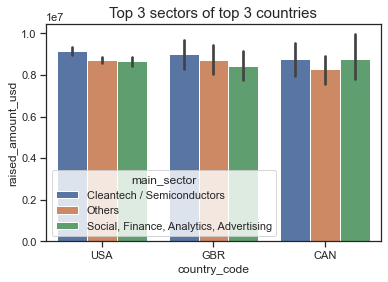

In [90]:
# A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart
### For Venture Type Investment 
#fig = plt.figure(figsize=(8,11))


plt.xlabel("Top 3 countries", fontsize= 12)
plt.ylabel("Total funding per sector", fontsize= 12)
plt.title("Top 3 sectors of top 3 countries", fontsize= 15)

sns.barplot(data=top3,x='country_code', y='raised_amount_usd', hue='main_sector')
plt.savefig("plot3.jpg")
plt.show()



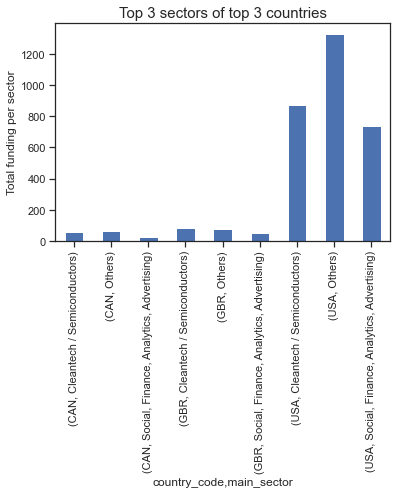

In [106]:
plt.xlabel("Top 3 countries", fontsize= 12)
plt.ylabel("Total funding per sector", fontsize= 12)
plt.title("Top 3 sectors of top 3 countries", fontsize= 15)
#sns.barplot(data=top3,x='country_code', y=, hue='main_sector')
top3.groupby(['country_code','main_sector'])['country_code'].count().plot(kind='bar')
plt.savefig("plot6.jpg")
plt.show()

#####  ************End of Document**************